In [1]:
using Pkg
Pkg.activate("F:/Tue/PhD/GP_playgroundcode")

  Activating project at `F:\Tue\PhD\GP_playgroundcode`


In [4]:
using ReactiveMP, KernelFunctions, Distributions, LinearAlgebra,GraphPPL, Rocket,Plots
using Revise 
using Flux, Zygote, ForwardDiff
include("utils_gp2.jl")
pgfplotsx()
import StatsFuns: log2π
import ReactiveMP: renderCVI

┌ Warning: Package ReactiveMP does not have KernelFunctions in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added KernelFunctions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading KernelFunctions into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [5]:
xmin, xmax = -3, 3  # Bounds of the data
N = 20# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=100));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

kernel_func =  Matern52Kernel() 
meanfunc   = (x) -> 0.0;
θ_init = 5.0 #our initial lengthscale
log_θ_init = log(θ_init)

1.6094379124341003

In [6]:
# test new thing
@model function gpprocess(n,kernelfunc,meanfunc,train,test)
    y = datavar(Float64,n)
    x = randomprocess(test,train)
    ### change here 
    η ~ NormalMeanVariance(log_θ_init, 2.)
    x ~ GaussianProcess(meanfunc,kernelfunc, η) where {meta = CVIApproximation(1000,100,ADAM(0.1)), 
                        pipeline = RequireMarginal(θ)}
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i,nothing,nothing,nothing)}
    end
    return x, γ, η, y  
end

In [7]:
function Distributions.entropy(pm::PointMass{F}) where {F <: Function}
    return ReactiveMP.InfCountingReal(Float64,-1)
end

function Distributions.entropy(pm::PointMass{F}) where {F <: Kernel}
    return ReactiveMP.InfCountingReal(Float64,-1)
end

###changed 
@average_energy GaussianProcess (q_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any, q_θ::Any) = begin
    q_out.finitemarginal
    return -entropy(q_out.finitemarginal)
end
############

@average_energy NormalMeanPrecision (q_out::Any, q_μ::GaussianProcess, q_τ::Any,meta::ProcessMeta) = begin
    m_right, cov_right = mean_cov(q_μ.finitemarginal)
    kernelf = q_μ.kernelfunction
    meanf   = q_μ.meanfunction
    test    = q_μ.testinput
    train   = q_μ.traininput
    μ_mean, μ_var = predMVN_fast(q_μ,test,[train[meta.index]],m_right)
    μ_var = clamp(μ_var[1],1e-8,huge)
    μ_mean = μ_mean[1]
    out_mean, out_var = mean_var(q_out)
    return (log2π - mean(log, q_τ) + mean(q_τ) * (μ_var + out_var + abs2(μ_mean - out_mean))) / 2
end

function ReactiveMP.entropy(p::GaussianProcess)
    return ReactiveMP.entropy(p.finitemarginal)
end

@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::PointMass, q_τ::GammaShapeRate, meta::ProcessMeta) = begin 
    return @call_rule NormalMeanPrecision(:μ, Marginalisation) (q_out=q_out,q_τ=q_τ,meta=nothing)
end
# @rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass) = begin 
#     return GaussianProcess(q_meanfunc.point,q_kernelfunc.point,nothing,nothing,nothing,nothing)
# end

In [8]:
# function ReactiveMP.messages_prod_fn(process::RandomProcess)
#     test  = process.test_input
#     train = process.train_input
#     # @show fieldnames(typeof(process))
#     return messages -> begin 
#         m_right,cov_right = make_multivariate_message(map(as_message, messages))

#         return Message(MvNormalMeanCovariance(m_right, cov_right), false, false)
#     end
# end
#### product rule for process messages  
function ReactiveMP.messages_prod_fn(process::RandomProcess)
    return ReactiveMP.marginal_prod_fn(process::RandomProcess)
end

# product rule for process marginal 
function ReactiveMP.marginal_prod_fn(process::RandomProcess)
    test  = process.test_input
    train = process.train_input

    return messages -> begin 
        message_vector = map(ReactiveMP.as_message, messages)
        process_message = getdata(message_vector[1])
        meanf = process_message.meanfunction
        kernelf = process_message.kernelfunction
        likelihood_messages = message_vector[2:end]
        m_right,cov_right = make_multivariate_message(likelihood_messages)
        
        #m, K = predMVN(meta,process_message,train, test, m_right,cov_right)
        m, K= predMVN(kernelf,meanf,train,test,m_right,cov_right) #Ismail code
        Kff = kernelmatrix(kernelf, test, test)
        invKff = cholinv(Kff + K)
        return Marginal(GaussianProcess(meanf,kernelf,MvNormalMeanCovariance(m,K),test,train, invKff),false,false)
    end
end

In [9]:
@constraints function gpconstraints()   
    q(x,γ,η) = q(x)q(γ)q(η)
end

gpconstraints (generic function with 1 method)

In [10]:
#missing rule 
@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::GammaShapeRate, ) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::PointMass, ) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::PointMass, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end
@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::NormalMeanVariance, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:θ, Marginalisation) (q_out::GaussianProcess, q_meanfunc::PointMass, q_kernelfunc::PointMass, 
        q_θ::UnivariateGaussianDistributionsFamily, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    #collect entities in meta
    n_iter = meta.num_iterations; 
    num_sample = meta.n_samples ;
    optimizer = meta.opt;
    RNG = meta.rng 
    #collect information from gaussian process q_out 
    test = q_out.testinput 
    meanf = q_meanfunc.point
    kernfunc(x) = with_lengthscale(q_kernelfunc.point, exp(x))
    y, Σ = mean_cov(q_out.finitemarginal)

    # do CVI 
    msg_in = q_θ
    λ_init = naturalparams(msg_in)
    #use "inv" instead of "cholinv"
    logp_nc(x) = -1/2 * (y - meanf.(test))' * inv(kernelmatrix(kernfunc(x),test,test) + Diagonal(Σ) + 1e-8*diageye(length(test))) * (y- meanf.(test)) - 1/2 * logdet(kernelmatrix(kernfunc(x),test,test) + Diagonal(Σ) + 1e-8*diageye(length(test)))
    λ = renderCVI(logp_nc, n_iter, optimizer, RNG, λ_init, msg_in)
    return convert(NormalMeanVariance, λ)
end

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::NormalWeightedMeanPrecision, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end


In [12]:
nits = 10
iresult = inference(
    model = Model(gpprocess, length(ytrain), kernel_func, meanfunc, xtrain,xtest),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),η = NormalMeanVariance(log_θ_init, 2.)),
    options = model_options(limit_stack_depth = 500),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,)
    # free_energy = true,
    # showprogress = true
)

Inference results:
-----------------------------------------
γ = GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=10.01, b=1.901296054131136), G...
η = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=10....
x = GaussianProcess[GaussianProcess(var"#15#16"(), Matern 5/2 Kernel (metric = Dista...


In [13]:
exp.(mean.(iresult.posteriors[:η]))

5-element Vector{Float64}:
 10.839528443025575
  9.848015710207735
  8.469243309303334
  6.589718644216339
  5.222958100198346

In [18]:
mean.(iresult.posteriors[:γ])

10-element Vector{Float64}:
  6.2594250602695265
 17.906204292539037
 51.03692708546613
 68.68410774962112
 68.5034944879535
 73.15918549248501
 82.17005169870762
 75.85013666882932
 84.12864252469522
 72.23404913376613

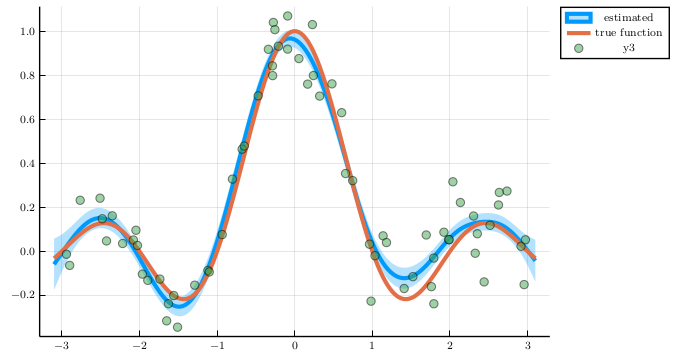

In [19]:
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5)

Plots.AnimatedGif("C:\\Users\\LENOVO\\AppData\\Local\\Temp\\jl_6x4ocnkcqQ.gif")
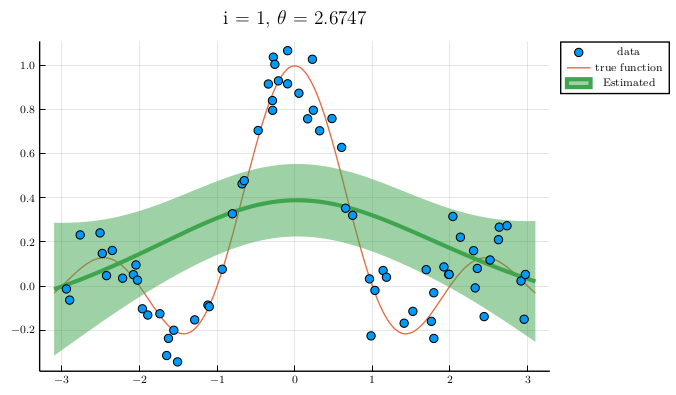

In [21]:
anim = Animation()
mean_marginal_θ = exp.(mean.(iresult.posteriors[:η]))
for i in 1:nits
    scatter(xtrain, ytrain; lab="data", title="i = $(i), θ = $(round(mean_marginal_θ[i],digits = 4))")
    plot!(xtest, f_true; lab="true function")
    plot!(xtest, mean(iresult.posteriors[:x][i].finitemarginal),
    ribbon=sqrt.(diag(cov(iresult.posteriors[:x][i].finitemarginal))),linewidth=3.0; lab="Estimated", lw=3.0)
    frame(anim)
end
gif(anim; show_msg=false, fps=2)
# gif(anim, "CVI_learning_anim.gif"; show_msg=false, fps=2)

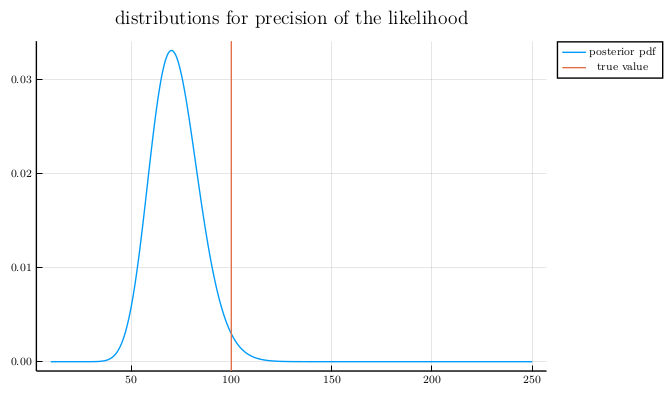

In [20]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)